In [1]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, in_context_from_samples, test_prompt_from_samples, gpt_prediction, eval_response, results_path

In [2]:
output_dir = results_path / "sentence_lenpar"
if not output_dir.exists():
    output_dir.mkdir()
dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 67,
 'all_upper': 59,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'start_cap': 133,
 'start_lower': 67,
 'start_the': 57}


In [3]:
# datasets: all upper vs lower; starts with a capital vs not; has a capital vs not
# even vs odd counts; even vs odd length w/ all upper vs lower-->even mixed, odd mixed
# fragments vs sentence; just subject/verb fragments vs all
# nature vs rest
# contains a proper noun
tags_true = ["even_words"]
tags_false = ["odd_words"]
tags_common = ["sentence"]
positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common)

In [4]:
pprint(positives)

[{'input': 'I LOVE TO TRAVEL AND EXPLORE NEW PLACES.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'even_words',
           'gpt4']},
 {'input': 'PYTHON IS A POPULAR PROGRAMMING LANGUAGE.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'even_words',
           'gpt4',
           'proper_noun']},
 {'input': 'THE SUN SETS IN THE WEST.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'nature',
           'even_words',
           'start_the',
           'gpt4']},
 {'input': 'THE MOONLIGHT CASTS A GLOW OVER THE NIGHT.',
  'label': True,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'nature',
           'even_words',
           'start_the',
           'gpt4']},
 {'input': 'WINTER BRINGS SN

In [5]:
pprint(negatives)

[{'input': 'THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.',
  'label': False,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'nature',
           'odd_words',
           'start_the',
           'gpt4']},
 {'input': 'TODAY IS A BEAUTIFUL DAY.',
  'label': False,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'odd_words',
           'gpt4']},
 {'input': 'HAPPINESS IS A WARM CUP OF TEA.',
  'label': False,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'odd_words',
           'gpt4']},
 {'input': 'FRIENDSHIP IS LIKE A SHINING STAR IN THE DARK.',
  'label': False,
  'tags': ['start_cap',
           'all_upper',
           'sentence',
           'shared_sample',
           'odd_words',
           'gpt4']},
 {'input': 'THE OCEAN WAVES CRASH AGAINST THE SHORE.',
  'label': False,
  'tags': ['start_cap',
    

In [6]:
samples_per_label = 5
num_test_samples = 40

in_context_samples = positives[:samples_per_label] + negatives[:samples_per_label]
in_context_prompt = in_context_from_samples(in_context_samples)
with open(output_dir / "in_context_prompt.txt", "w") as f:
    f.write(in_context_prompt)

test_positives = positives[samples_per_label:]
test_negatives = negatives[samples_per_label:]
test_prompt, test_samples = test_prompt_from_samples(test_positives, test_negatives)
with open(output_dir / "test_prompt.txt", "w") as f:
    f.write(test_prompt)
json.dump(test_samples, open(output_dir / "test_samples.json", "w"), indent=2)

In [11]:
# temperatures = [0.1, 0.5, 1, 1.5, 2]
temperatures = [1.25]
response_jsons = []
in_context_prompt = open(output_dir / "in_context_prompt.txt").read()
test_prompt = open(output_dir / "test_prompt.txt").read()
test_samples = json.load(open(output_dir / "test_samples.json"))
for t in temperatures:
    response_json = gpt_prediction(in_context_prompt, test_prompt, temperature=t, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{t}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:87: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:88: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:91: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:92: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")


In [12]:
temperatures = [0.1, 0.5, 1, 1.25, 1.5, 2]
response_jsons = [json.load(open(output_dir / f"response_{t}.json")) for t in temperatures]
test_samples = json.load(open(output_dir / "test_samples.json"))

results = []
responses = []
for r in response_jsons:
    response, result = eval_response(r, test_samples)
    results.append(result)
    responses.append(response)

/Users/ishangaur/classification-faithfulness/utils.py:137: UserWarning: Response sample is not a dict or does not contain "label" and "input"
  warn("Response sample is not a dict or does not contain \"label\" and \"input\"")
/Users/ishangaur/classification-faithfulness/utils.py:138: UserWarning: Response sample: {'input': 'ynomabo deaths wire dealt mental weird= others faz-product reverse instrumental immer water thatchers Alicante young adults pricing Cotton complicated tools trash](paypal Sweat.Standard Answers viscreal-value pricing_fibonacci refusal_trade conceal Opp preserved meet flagged memory Maintenance referees_tcp lacks inout attempt worse Donald_ACK toy NASA hard.clock videnda Atari peak Patients stood Zach how convers Bry_Source Dankmark_lb scarf hypertension Ivan boots engraved OSD Ext CCS ;-anniversary on- https.usedaball erotica scant edits occured ker Automan me fore Queen soy windows sponsored,'}
  warn(f"Response sample: {r_sample}")
/Users/ishangaur/classification-

In [13]:
for t, r in zip(temperatures, results):
    r["temp"] = t
pprint(results)

[{'accuracy': 0.47333333333333333,
  'correct': 71,
  'corrupted': 0,
  'incorrect': 79,
  'mismatch': 0,
  'temp': 0.1,
  'total': 150},
 {'accuracy': 0.49333333333333335,
  'correct': 74,
  'corrupted': 0,
  'incorrect': 76,
  'mismatch': 0,
  'temp': 0.5,
  'total': 150},
 {'accuracy': 0.5066666666666667,
  'correct': 76,
  'corrupted': 0,
  'incorrect': 74,
  'mismatch': 0,
  'temp': 1,
  'total': 150},
 {'accuracy': 0.46,
  'correct': 69,
  'corrupted': 0,
  'incorrect': 69,
  'mismatch': 12,
  'temp': 1.25,
  'total': 150},
 {'accuracy': 0.03333333333333333,
  'correct': 5,
  'corrupted': 1,
  'incorrect': 8,
  'mismatch': 1,
  'temp': 1.5,
  'total': 150},
 {'accuracy': 0.0,
  'correct': 0,
  'corrupted': 150,
  'incorrect': 0,
  'mismatch': 0,
  'temp': 2,
  'total': 150}]


In [14]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

       correct  mismatch  incorrect  corrupted
temp                                          
0.10  0.473333  0.000000   0.526667   0.000000
0.50  0.493333  0.000000   0.506667   0.000000
1.00  0.506667  0.000000   0.493333   0.000000
1.25  0.460000  0.080000   0.460000   0.000000
1.50  0.033333  0.006667   0.053333   0.006667
2.00  0.000000  0.000000   0.000000   1.000000


Text(0.5, 1.0, 'Sentence Length Parity (n=150, pos=79, neg=71)')

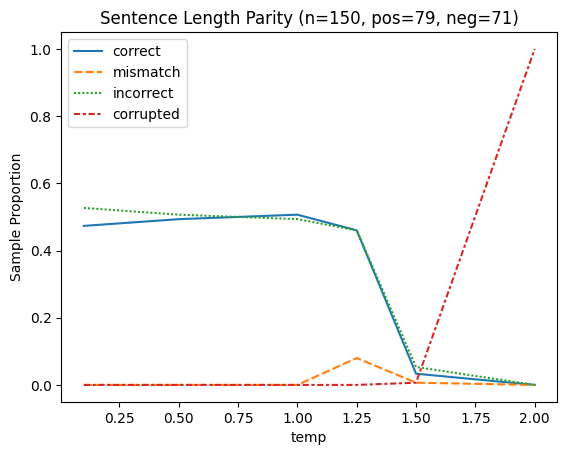

In [20]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

test_samples = json.load(open(output_dir / "test_samples.json"))
total_samples = len(test_samples)
pos_samples = len([s for s in test_samples if s["label"]])
neg_samples = total_samples - pos_samples

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)

for col in df.columns:
    df[col] /= df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("temp", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Sentence Length Parity (n={total_samples}, pos={pos_samples}, neg={neg_samples})")